In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [143]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Girona 2-1 Barcelona - LaLiga 2025_2026 Live.html"
fotmob_matchId = 4837347

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [144]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [145]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [146]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [147]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [148]:
df = df.merge(dfp, on='playerId', how='left')

In [149]:
df.columns

Index(['id', 'eventId', 'minute', 'teamId', 'playerId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'second', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isShot', 'blockedX', 'blockedY', 'cardType', 'isGoal', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [150]:
df

,id,eventId,minute,teamId,playerId,x,y,expandedMinute,period,type,...,blockedY,cardType,isGoal,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.901303e+09,11006,0,2783,410504.0,109.80,22.88,0,NaN,NaN,...,NaN,NaN,NaN,Girona,Barcelona,19.0,Vladyslav Vanat,FW,True,V. Vanat
1,2.901292e+09,2,0,65,NaN,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Barcelona,Girona,NaN,NaN,NaN,NaN,NaN
2,2.901292e+09,2,0,2783,NaN,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Girona,Barcelona,NaN,NaN,NaN,NaN,NaN
3,2.901292e+09,3,0,65,349760.0,60.00,40.00,0,NaN,NaN,...,NaN,NaN,NaN,Barcelona,Girona,7.0,Ferran Torres,FW,True,F. Torres
4,2.901292e+09,4,0,65,498386.0,43.08,38.64,0,NaN,NaN,...,NaN,NaN,NaN,Barcelona,Girona,5.0,Pau Cubarsí,DC,True,P. Cubarsí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,2.901336e+09,1160,100,65,NaN,0.00,0.00,103,NaN,NaN,...,NaN,NaN,NaN,Barcelona,Girona,NaN,NaN,NaN,NaN,NaN
1730,2.901336e+09,721,0,2783,NaN,0.00,0.00,13,NaN,NaN,...,NaN,NaN,NaN,Girona,Barcelona,NaN,NaN,NaN,NaN,NaN
1731,2.901336e+09,1161,0,65,NaN,0.00,0.00,13,NaN,NaN,...,NaN,NaN,NaN,Barcelona,Girona,NaN,NaN,NaN,NaN,NaN
1732,2.901262e+09,1,0,2783,NaN,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Girona,Barcelona,NaN,NaN,NaN,NaN,NaN


In [151]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,104732,13,Paulo Gazzaniga,GK,True,P. Gazzaniga
1,481851,2,Hugo Rincón,DR,True,H. Rincón
2,478314,12,Vitor Reis,DC,True,V. Reis
3,70033,17,Daley Blind,DC,True,D. Blind
4,444239,4,Arnau Martínez,DL,True,A. Martínez
5,25191,20,Axel Witsel,DMC,True,A. Witsel
6,372473,23,Iván Martín,DMC,True,I. Martín
7,231125,15,Viktor Tsygankov,AMR,True,V. Tsygankov
8,132962,11,Thomas Lemar,AMC,True,T. Lemar
9,368519,21,Bryan Gil,AML,True,B. Gil


In [152]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [153]:
df=df.reset_index()

In [154]:
df

,index,id,eventId,minute,teamId,playerId,x,y,expandedMinute,period,...,blockedY,cardType,isGoal,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,3,2.901292e+09,3,0,65,349760.0,60.00,40.00,0,NaN,...,NaN,NaN,NaN,Barcelona,Girona,7.0,Ferran Torres,FW,True,F. Torres
1,4,2.901292e+09,4,0,65,498386.0,43.08,38.64,0,NaN,...,NaN,NaN,NaN,Barcelona,Girona,5.0,Pau Cubarsí,DC,True,P. Cubarsí
2,5,2.901292e+09,5,0,65,368091.0,40.68,55.44,0,NaN,...,NaN,NaN,NaN,Barcelona,Girona,24.0,Eric García,DC,True,E. García
3,6,2.901292e+09,6,0,65,498386.0,30.48,38.96,0,NaN,...,NaN,NaN,NaN,Barcelona,Girona,5.0,Pau Cubarsí,DC,True,P. Cubarsí
4,7,2.901292e+09,7,0,65,301019.0,32.04,12.56,0,NaN,...,NaN,NaN,NaN,Barcelona,Girona,23.0,Jules Koundé,DR,True,J. Koundé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,1719,2.901336e+09,1156,99,65,435529.0,77.04,15.92,102,NaN,...,NaN,NaN,NaN,Barcelona,Girona,19.0,Roony Bardghji,Sub,NaN,R. Bardghji
1230,1720,2.901336e+09,718,99,2783,478314.0,5.76,40.56,102,NaN,...,NaN,NaN,NaN,Girona,Barcelona,12.0,Vitor Reis,DC,True,V. Reis
1231,1723,2.901336e+09,1158,99,65,463838.0,96.72,26.64,102,NaN,...,NaN,NaN,NaN,Barcelona,Girona,16.0,Fermín López,MC,True,F. López
1232,1726,2.901337e+09,1165,99,65,384711.0,108.84,37.52,102,NaN,...,NaN,NaN,NaN,Barcelona,Girona,4.0,Ronald Araujo,Sub,NaN,R. Araujo


In [155]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [156]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN
1,0,3.0,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
2,0,6.0,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,NaN,NaN,NaN
3,0,8.0,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
4,0,11.0,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,99,42.0,77.04,15.92,109.32,44.64,Barcelona,19.0,Sub,R. Bardghji,NaN,NaN,NaN
1230,99,44.0,5.76,40.56,23.28,53.36,Girona,12.0,DC,V. Reis,NaN,NaN,NaN
1231,99,45.0,96.72,26.64,108.84,37.52,Barcelona,16.0,MC,F. López,NaN,NaN,NaN
1232,99,46.0,108.84,37.52,109.20,39.36,Barcelona,4.0,Sub,R. Araujo,NaN,NaN,NaN


In [157]:
#Passing Network Girona

In [158]:
df.columns

Index(['minute', 'second', 'x', 'y', 'endX', 'endY', 'teamName', 'shirtNo',
       'position', 'shortName', 'goalMouthY', 'isShot', 'isGoal'],
      dtype='object')

In [159]:
df_gir=df[df["teamName"]=="Girona"]
df_gir

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
6,0,17.0,96.12,65.28,89.76,54.56,Girona,11.0,AMC,T. Lemar,NaN,NaN,NaN
7,0,19.0,89.76,55.44,109.80,22.88,Girona,23.0,DMC,I. Martín,NaN,NaN,NaN
47,2,32.0,33.36,48.72,46.44,48.24,Girona,17.0,DC,D. Blind,NaN,NaN,NaN
49,2,37.0,31.20,65.12,37.92,74.48,Girona,4.0,DL,A. Martínez,NaN,NaN,NaN
58,3,1.0,27.60,59.84,45.48,64.40,Girona,17.0,DC,D. Blind,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,98,2.0,11.76,44.40,18.84,58.80,Girona,17.0,DC,D. Blind,NaN,NaN,NaN
1227,98,6.0,3.24,37.28,9.00,30.96,Girona,8.0,Sub,F. Beltrán,NaN,NaN,NaN
1228,98,7.0,11.64,23.12,51.00,52.56,Girona,2.0,DR,H. Rincón,NaN,NaN,NaN
1230,99,44.0,5.76,40.56,23.28,53.36,Girona,12.0,DC,V. Reis,NaN,NaN,NaN


In [160]:
firstSub=67

In [161]:
df_gir=df_gir[df_gir["minute"]<firstSub]
df_gir

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
6,0,17.0,96.12,65.28,89.76,54.56,Girona,11.0,AMC,T. Lemar,NaN,NaN,NaN
7,0,19.0,89.76,55.44,109.80,22.88,Girona,23.0,DMC,I. Martín,NaN,NaN,NaN
47,2,32.0,33.36,48.72,46.44,48.24,Girona,17.0,DC,D. Blind,NaN,NaN,NaN
49,2,37.0,31.20,65.12,37.92,74.48,Girona,4.0,DL,A. Martínez,NaN,NaN,NaN
58,3,1.0,27.60,59.84,45.48,64.40,Girona,17.0,DC,D. Blind,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,64,38.0,11.04,60.00,40.08,60.96,Girona,4.0,DL,A. Martínez,NaN,NaN,NaN
882,65,23.0,1.32,42.32,11.04,41.28,Girona,13.0,GK,P. Gazzaniga,NaN,NaN,NaN
883,65,23.0,5.04,42.08,13.08,49.28,Girona,12.0,DC,V. Reis,NaN,NaN,NaN
884,65,24.0,15.60,47.76,44.52,46.64,Girona,20.0,DMC,A. Witsel,NaN,NaN,NaN


In [162]:
df_gir["passer"]=df_gir["shirtNo"]
df_gir["recipient"]=df_gir["shirtNo"].shift(-1)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\455673392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir["passer"]=df_gir["shirtNo"]
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\455673392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir["recipient"]=df_gir["shirtNo"].shift(-1)


In [163]:
df_gir

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
6,0,17.0,96.12,65.28,89.76,54.56,Girona,11.0,AMC,T. Lemar,NaN,NaN,NaN,11.0,23.0
7,0,19.0,89.76,55.44,109.80,22.88,Girona,23.0,DMC,I. Martín,NaN,NaN,NaN,23.0,17.0
47,2,32.0,33.36,48.72,46.44,48.24,Girona,17.0,DC,D. Blind,NaN,NaN,NaN,17.0,4.0
49,2,37.0,31.20,65.12,37.92,74.48,Girona,4.0,DL,A. Martínez,NaN,NaN,NaN,4.0,17.0
58,3,1.0,27.60,59.84,45.48,64.40,Girona,17.0,DC,D. Blind,NaN,NaN,NaN,17.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,64,38.0,11.04,60.00,40.08,60.96,Girona,4.0,DL,A. Martínez,NaN,NaN,NaN,4.0,13.0
882,65,23.0,1.32,42.32,11.04,41.28,Girona,13.0,GK,P. Gazzaniga,NaN,NaN,NaN,13.0,12.0
883,65,23.0,5.04,42.08,13.08,49.28,Girona,12.0,DC,V. Reis,NaN,NaN,NaN,12.0,20.0
884,65,24.0,15.60,47.76,44.52,46.64,Girona,20.0,DMC,A. Witsel,NaN,NaN,NaN,20.0,23.0


In [164]:
pas=pd.to_numeric(df_gir["passer"],downcast="integer")
rec=pd.to_numeric(df_gir["recipient"],downcast="integer")

df_gir["passer"]=pas
df_gir["recipient"]=rec

df_gir.head()

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\8525165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir["passer"]=pas
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\8525165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir["recipient"]=rec


,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
6,0,17.0,96.12,65.28,89.76,54.56,Girona,11.0,AMC,T. Lemar,NaN,NaN,NaN,11,23.0
7,0,19.0,89.76,55.44,109.80,22.88,Girona,23.0,DMC,I. Martín,NaN,NaN,NaN,23,17.0
47,2,32.0,33.36,48.72,46.44,48.24,Girona,17.0,DC,D. Blind,NaN,NaN,NaN,17,4.0
49,2,37.0,31.20,65.12,37.92,74.48,Girona,4.0,DL,A. Martínez,NaN,NaN,NaN,4,17.0
58,3,1.0,27.60,59.84,45.48,64.40,Girona,17.0,DC,D. Blind,NaN,NaN,NaN,17,4.0


In [165]:
df_gir=df_gir.drop(["goalMouthY","isShot","isGoal"],axis=1)

In [166]:
average_locations=df_gir.groupby("passer").agg({"x":["mean"],"y":["mean","count"]})
average_locations.columns=["x","y","count"]
average_locations

,x,y,count
passer,,,
2,48.932000,15.778667,30
4,45.187500,65.810000,32
11,71.869565,46.076522,23
12,28.658571,30.305714,28
13,9.555556,39.522963,27
15,70.524000,19.264000,20
17,27.666000,56.298000,40
19,88.043077,57.569231,13
20,43.878621,48.753103,29


In [167]:
pass_between = (
    df_gir
    .groupby(["passer", "recipient"])
    .size()
    .reset_index(name="pass_count")
)

pass_between.head()

,passer,recipient,pass_count
0,2,2.0,2
1,2,4.0,2
2,2,11.0,3
3,2,12.0,6
4,2,13.0,1


In [168]:
pass_between = pass_between.merge(average_locations, left_on='passer', right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient', right_index=True, suffixes=['', '_end'])

pass_between.head()

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,2,2.0,2,48.932,15.778667,30,48.932000,15.778667,30
1,2,4.0,2,48.932,15.778667,30,45.187500,65.810000,32
2,2,11.0,3,48.932,15.778667,30,71.869565,46.076522,23
3,2,12.0,6,48.932,15.778667,30,28.658571,30.305714,28
4,2,13.0,1,48.932,15.778667,30,9.555556,39.522963,27


In [169]:
pass_between=pass_between[pass_between["pass_count"]>3]
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
3,2,12.0,6,48.932000,15.778667,30,28.658571,30.305714,28
5,2,15.0,4,48.932000,15.778667,30,70.524000,19.264000,20
9,2,23.0,6,48.932000,15.778667,30,51.484444,29.004444,27
16,4,17.0,6,45.187500,65.810000,32,27.666000,56.298000,40
17,4,19.0,5,45.187500,65.810000,32,88.043077,57.569231,13
18,4,20.0,7,45.187500,65.810000,32,43.878621,48.753103,29
22,11,4.0,5,71.869565,46.076522,23,45.187500,65.810000,32
29,11,23.0,5,71.869565,46.076522,23,51.484444,29.004444,27
34,12,13.0,8,28.658571,30.305714,28,9.555556,39.522963,27
36,12,17.0,5,28.658571,30.305714,28,27.666000,56.298000,40


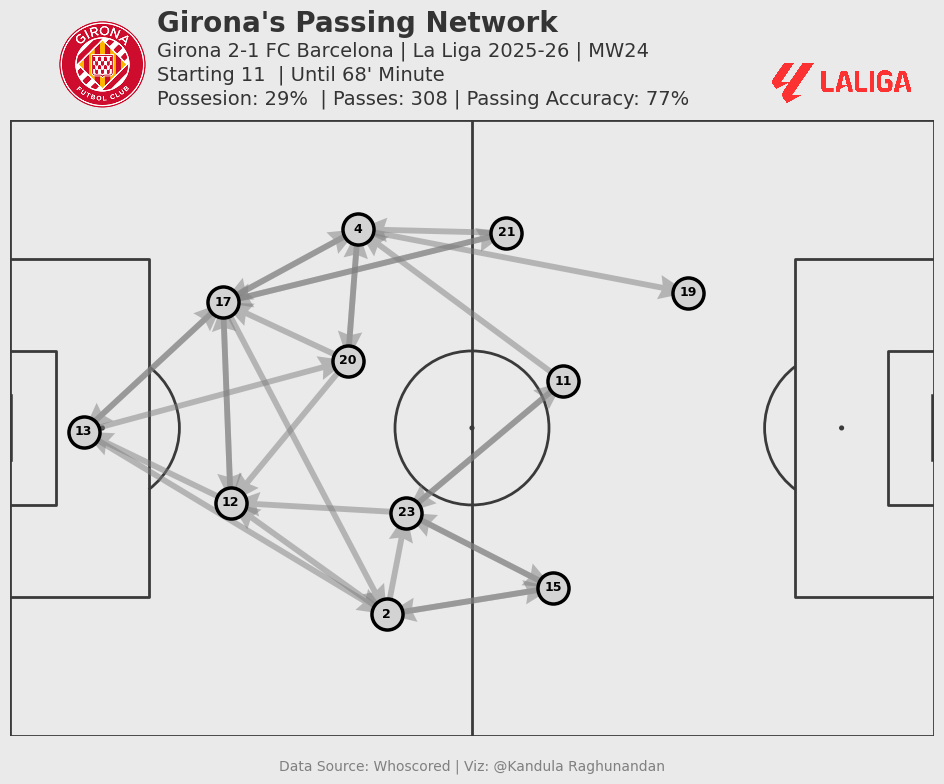

In [170]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

arrows=pitch.arrows(pass_between.x,
                    pass_between.y,
                    pass_between.x_end,
                    pass_between.y_end,
                    ax=ax,
                    width=4.2,
                    headwidth=4.2,
                    color="#808080",
                    alpha=.5)

nodes=pitch.scatter(average_locations.x,
                    average_locations.y,
                    s=500,
                    color="#d3d3d3",
                    edgecolor="black",
                    linewidth=2.5,
                    alpha=1,
                    ax=ax)

for passer, row in average_locations.iterrows():
    ax.text(
        row['x'],    # x position
        row['y'],    # y position
        str(passer),       # the index (playerId)
        ha='center', va='center',
        fontsize=9, color='black', weight='bold'
    )

fig.text(0.25, 0.99, "Girona's Passing Network", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.25, 0.96, "Girona 2-1 FC Barcelona | La Liga 2025-26 | MW24",fontsize=14, color='#343434')
fig.text(0.25, 0.93, "Starting 11  | Until 68' Minute",fontsize=14, color='#343434')
fig.text(0.25, 0.90, "Possesion: 29%  | Passes: 308 | Passing Accuracy: 77%",fontsize=14, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/La Liga/Girona.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/La Liga/La Liga Logo.png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.25, xy=(0.1, 1.09))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.06))

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Girona 2-1 Barcelona - LaLiga 2025_2026 Live_files\New folder\gir_pass_net.png",bbox_inches='tight')

In [171]:
#Passing Network Barcelona

In [172]:
df_bar=df[df["teamName"]=="Barcelona"]
df_bar

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN
1,0,3.0,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
2,0,6.0,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,NaN,NaN,NaN
3,0,8.0,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
4,0,11.0,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,98,3.0,104.76,28.88,NaN,NaN,Barcelona,19.0,Sub,R. Bardghji,45.84,True,NaN
1226,98,4.0,106.80,36.64,108.24,40.24,Barcelona,4.0,Sub,R. Araujo,NaN,NaN,NaN
1229,99,42.0,77.04,15.92,109.32,44.64,Barcelona,19.0,Sub,R. Bardghji,NaN,NaN,NaN
1231,99,45.0,96.72,26.64,108.84,37.52,Barcelona,16.0,MC,F. López,NaN,NaN,NaN


In [173]:
firstSub=63

In [174]:
df_bar=df_bar[df_bar["minute"]<firstSub]
df_bar

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN
1,0,3.0,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
2,0,6.0,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,NaN,NaN,NaN
3,0,8.0,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
4,0,11.0,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,60,36.0,45.00,35.28,59.40,48.24,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
829,60,37.0,59.40,48.24,57.72,40.40,Barcelona,20.0,MC,D. Olmo,NaN,NaN,NaN
835,60,59.0,6.12,32.24,7.56,18.72,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN
838,62,57.0,60.24,39.84,52.92,40.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN


In [175]:
df_bar["passer"]=df_bar["shirtNo"]
df_bar["recipient"]=df_bar["shirtNo"].shift(-1)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\3017347690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar["passer"]=df_bar["shirtNo"]
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\3017347690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar["recipient"]=df_bar["shirtNo"].shift(-1)


In [176]:
df_bar

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,0,0.0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN,7.0,5.0
1,0,3.0,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN,5.0,24.0
2,0,6.0,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,NaN,NaN,NaN,24.0,5.0
3,0,8.0,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN,5.0,23.0
4,0,11.0,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,NaN,NaN,NaN,23.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,60,36.0,45.00,35.28,59.40,48.24,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN,5.0,20.0
829,60,37.0,59.40,48.24,57.72,40.40,Barcelona,20.0,MC,D. Olmo,NaN,NaN,NaN,20.0,5.0
835,60,59.0,6.12,32.24,7.56,18.72,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN,5.0,7.0
838,62,57.0,60.24,39.84,52.92,40.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN,7.0,21.0


In [177]:
pas=pd.to_numeric(df_bar["passer"],downcast="integer")
rec=pd.to_numeric(df_bar["recipient"],downcast="integer")

df_bar["passer"]=pas
df_bar["recipient"]=rec

df_bar.head()

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\2619594287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar["passer"]=pas
C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\2619594287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar["recipient"]=rec


,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal,passer,recipient
0,0,0.0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,NaN,NaN,NaN,7,5.0
1,0,3.0,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN,5,24.0
2,0,6.0,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,NaN,NaN,NaN,24,5.0
3,0,8.0,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,NaN,NaN,NaN,5,23.0
4,0,11.0,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,NaN,NaN,NaN,23,16.0


In [178]:
df_bar=df_bar.drop(["goalMouthY","isShot","isGoal"],axis=1)

In [179]:
average_locations=df_bar.groupby("passer").agg({"x":["mean"],"y":["mean","count"]})
average_locations.columns=["x","y","count"]
average_locations

,x,y,count
passer,,,
5,47.367742,35.565591,93
7,83.128000,46.458667,15
10,82.314894,14.478298,47
11,79.783448,54.093793,29
13,16.027500,39.862500,32
16,69.642353,26.287059,34
18,65.988000,68.818000,40
20,69.091111,42.691852,54
21,66.480000,34.816970,66


In [180]:
pass_between = (
    df_bar
    .groupby(["passer", "recipient"])
    .size()
    .reset_index(name="pass_count")
)

pass_between.head()

,passer,recipient,pass_count
0,5,7.0,3
1,5,10.0,5
2,5,13.0,7
3,5,16.0,2
4,5,18.0,3


In [181]:
pass_between = pass_between.merge(average_locations, left_on='passer', right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient', right_index=True, suffixes=['', '_end'])

pass_between.head()

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,5,7.0,3,47.367742,35.565591,93,83.128000,46.458667,15
1,5,10.0,5,47.367742,35.565591,93,82.314894,14.478298,47
2,5,13.0,7,47.367742,35.565591,93,16.027500,39.862500,32
3,5,16.0,2,47.367742,35.565591,93,69.642353,26.287059,34
4,5,18.0,3,47.367742,35.565591,93,65.988000,68.818000,40


In [182]:
pass_between=pass_between[pass_between["pass_count"]>3]
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
1,5,10.0,5,47.367742,35.565591,93,82.314894,14.478298,47
2,5,13.0,7,47.367742,35.565591,93,16.027500,39.862500,32
5,5,20.0,8,47.367742,35.565591,93,69.091111,42.691852,54
6,5,21.0,11,47.367742,35.565591,93,66.480000,34.816970,66
7,5,23.0,27,47.367742,35.565591,93,53.863500,13.663000,80
8,5,24.0,27,47.367742,35.565591,93,55.880597,57.777910,67
17,10,5.0,7,82.314894,14.478298,47,47.367742,35.565591,93
21,10,13.0,4,82.314894,14.478298,47,16.027500,39.862500,32
22,10,16.0,7,82.314894,14.478298,47,69.642353,26.287059,34
24,10,20.0,4,82.314894,14.478298,47,69.091111,42.691852,54


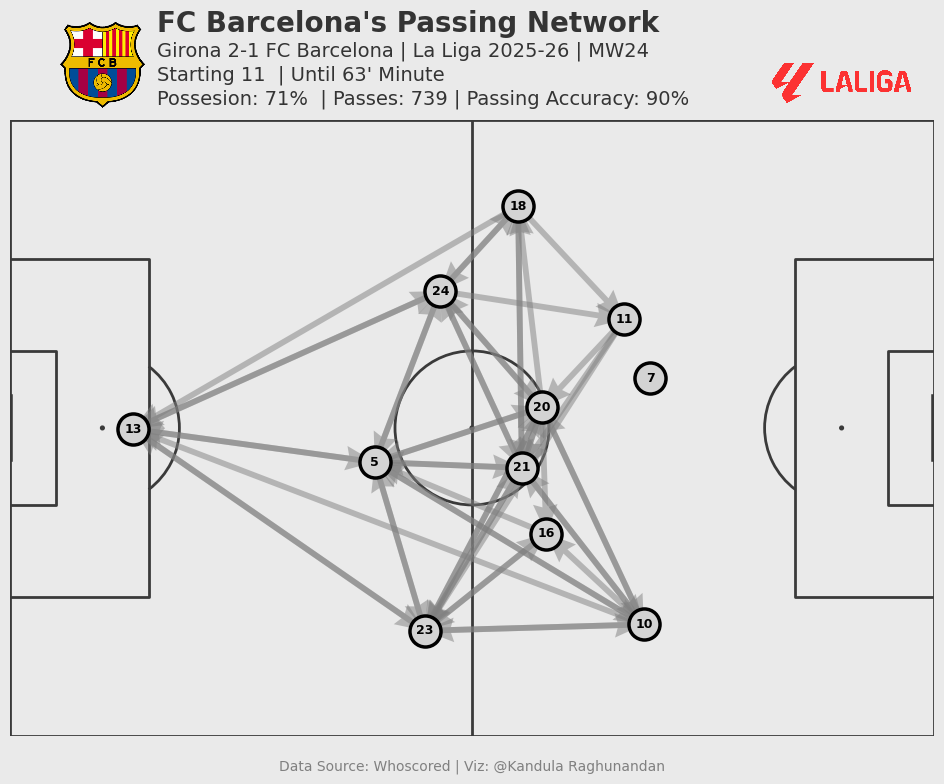

In [183]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

arrows=pitch.arrows(pass_between.x,
                    pass_between.y,
                    pass_between.x_end,
                    pass_between.y_end,
                    ax=ax,
                    width=4.2,
                    headwidth=4.2,
                    color="#808080",
                    alpha=.5)

nodes=pitch.scatter(average_locations.x,
                    average_locations.y,
                    s=500,
                    color="#d3d3d3",
                    edgecolor="black",
                    linewidth=2.5,
                    alpha=1,
                    ax=ax)

for passer, row in average_locations.iterrows():
    ax.text(
        row['x'],    # x position
        row['y'],    # y position
        str(passer),       # the index (playerId)
        ha='center', va='center',
        fontsize=9, color='black', weight='bold'
    )

fig.text(0.25, 0.99, "FC Barcelona's Passing Network", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.25, 0.96, "Girona 2-1 FC Barcelona | La Liga 2025-26 | MW24",fontsize=14, color='#343434')
fig.text(0.25, 0.93, "Starting 11  | Until 63' Minute",fontsize=14, color='#343434')
fig.text(0.25, 0.90, "Possesion: 71%  | Passes: 739 | Passing Accuracy: 90% ",fontsize=14, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/La Liga/Barcelona.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/La Liga/La Liga Logo.png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.25, xy=(0.1, 1.09))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.06))

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Girona 2-1 Barcelona - LaLiga 2025_2026 Live_files\New folder\fcb_pass_net.png",bbox_inches='tight')

In [184]:
#voronoi diagram

In [185]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna()))
]

In [186]:
df=df.reset_index()

In [187]:
df_vor=df[["x","y","endX","endY","teamName","shirtNo","position","shortName","minute"]]

In [188]:
df_vor

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute
0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,0
1,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,0
2,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,0
3,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,0
4,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,0
...,...,...,...,...,...,...,...,...,...
1189,77.04,15.92,109.32,44.64,Barcelona,19.0,Sub,R. Bardghji,99
1190,5.76,40.56,23.28,53.36,Girona,12.0,DC,V. Reis,99
1191,96.72,26.64,108.84,37.52,Barcelona,16.0,MC,F. López,99
1192,108.84,37.52,109.20,39.36,Barcelona,4.0,Sub,R. Araujo,99


In [189]:
firstSub=63

In [190]:
df_vor=df_vor[df_vor["minute"]<firstSub]

In [191]:
df_vor

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute
0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,0
1,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,0
2,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,0
3,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,0
4,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,0
...,...,...,...,...,...,...,...,...,...
811,113.04,73.20,113.52,45.36,Girona,19.0,FW,V. Vanat,60
812,6.12,32.24,7.56,18.72,Barcelona,5.0,DC,P. Cubarsí,60
813,115.68,58.64,115.80,39.52,Girona,19.0,FW,V. Vanat,60
814,60.24,39.84,52.92,40.80,Barcelona,7.0,FW,F. Torres,62


In [192]:
df_vor["passer"]=df_vor["shirtNo"]

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\4059153937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor["passer"]=df_vor["shirtNo"]


In [193]:
pas=pd.to_numeric(df_vor["passer"],downcast="integer")

In [194]:
df_vor["passer"]=pas

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_23048\25595984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor["passer"]=pas


In [195]:
df_vor

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute,passer
0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,0,7
1,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,0,5
2,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,0,24
3,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,0,5
4,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,0,23
...,...,...,...,...,...,...,...,...,...,...
811,113.04,73.20,113.52,45.36,Girona,19.0,FW,V. Vanat,60,19
812,6.12,32.24,7.56,18.72,Barcelona,5.0,DC,P. Cubarsí,60,5
813,115.68,58.64,115.80,39.52,Girona,19.0,FW,V. Vanat,60,19
814,60.24,39.84,52.92,40.80,Barcelona,7.0,FW,F. Torres,62,7


In [196]:
df_gir=df_vor[df_vor["teamName"]=="Girona"]

In [197]:
df_gir

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute,passer
6,96.12,65.28,89.76,54.56,Girona,11.0,AMC,T. Lemar,0,11
7,89.76,55.44,109.80,22.88,Girona,23.0,DMC,I. Martín,0,23
47,33.36,48.72,46.44,48.24,Girona,17.0,DC,D. Blind,2,17
49,31.20,65.12,37.92,74.48,Girona,4.0,DL,A. Martínez,2,4
58,27.60,59.84,45.48,64.40,Girona,17.0,DC,D. Blind,3,17
...,...,...,...,...,...,...,...,...,...,...
808,70.08,64.80,90.84,72.48,Girona,4.0,DL,A. Martínez,60,4
809,92.88,62.88,82.08,62.00,Girona,19.0,FW,V. Vanat,60,19
810,88.20,58.88,109.32,72.00,Girona,4.0,DL,A. Martínez,60,4
811,113.04,73.20,113.52,45.36,Girona,19.0,FW,V. Vanat,60,19


In [198]:
df_bar=df_vor[df_vor["teamName"]=="Barcelona"]

In [199]:
df_bar

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute,passer
0,60.00,40.00,40.44,36.80,Barcelona,7.0,FW,F. Torres,0,7
1,43.08,38.64,40.68,57.12,Barcelona,5.0,DC,P. Cubarsí,0,5
2,40.68,55.44,30.48,41.12,Barcelona,24.0,DC,E. García,0,24
3,30.48,38.96,32.04,12.56,Barcelona,5.0,DC,P. Cubarsí,0,5
4,32.04,12.56,45.84,5.60,Barcelona,23.0,DR,J. Koundé,0,23
...,...,...,...,...,...,...,...,...,...,...
805,45.00,35.28,59.40,48.24,Barcelona,5.0,DC,P. Cubarsí,60,5
806,59.40,48.24,57.72,40.40,Barcelona,20.0,MC,D. Olmo,60,20
812,6.12,32.24,7.56,18.72,Barcelona,5.0,DC,P. Cubarsí,60,5
814,60.24,39.84,52.92,40.80,Barcelona,7.0,FW,F. Torres,62,7


In [200]:
df_gir_vor=df_gir.groupby("passer").agg({"x":["mean"],"y":["mean"]})
df_gir_vor["Team"]=0

In [201]:
df_gir_vor=df_gir_vor.reset_index()

In [202]:
df_gir_vor

,passer,x,y,Team
,,mean,mean,
0,2,48.932000,15.778667,0
1,4,46.289032,65.997419,0
2,11,69.872727,46.374545,0
3,12,29.533333,29.869630,0
4,13,9.872308,39.415385,0
5,15,72.546667,19.000000,0
6,17,28.295385,56.510769,0
7,19,82.776000,62.768000,0
8,20,44.888571,48.788571,0


In [203]:
df_bar_vor=df_bar.groupby("passer").agg({"x":["mean"],"y":["mean"]})
df_bar_vor["Team"]=1

In [204]:
df_bar_vor=df_bar_vor.reset_index()

In [205]:
df_bar_vor["x"]=120-df_bar_vor["x"]
df_bar_vor["y"]=80-df_bar_vor["y"]

In [206]:
df_bar_vor

,passer,x,y,Team
,,mean,mean,
0,5,73.290000,44.461739,1
1,7,41.076923,34.166154,1
2,10,39.977143,67.582857,1
3,11,44.073600,24.960000,1
4,13,103.972500,40.137500,1
5,16,53.744516,55.323871,1
6,18,54.012000,11.182000,1
7,20,51.416604,37.509434,1
8,21,53.520000,45.183030,1


In [207]:
df_voronoi = pd.concat([df_gir_vor,df_bar_vor], ignore_index=True)

In [208]:
df_voronoi.columns = df_voronoi.columns.droplevel(1)

In [209]:
df_voronoi

,passer,x,y,Team
0,2,48.932000,15.778667,0
1,4,46.289032,65.997419,0
2,11,69.872727,46.374545,0
3,12,29.533333,29.869630,0
4,13,9.872308,39.415385,0
5,15,72.546667,19.000000,0
6,17,28.295385,56.510769,0
7,19,82.776000,62.768000,0
8,20,44.888571,48.788571,0
9,21,62.388571,66.179048,0


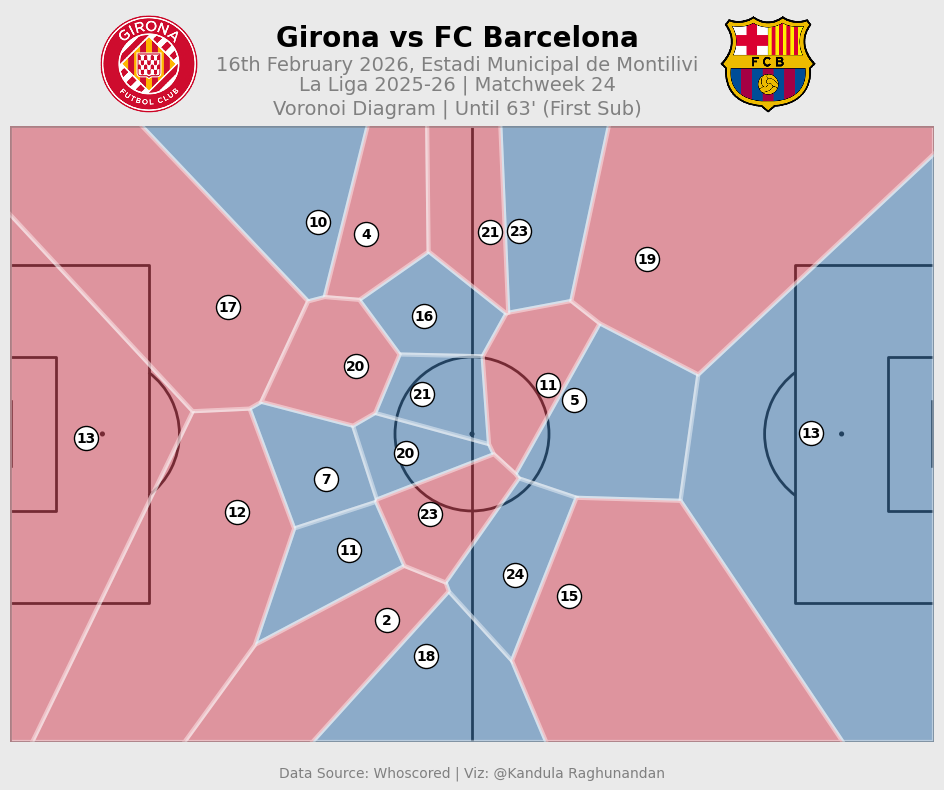

In [210]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

x=df_voronoi.x
y=df_voronoi.y
team1,team2=pitch.voronoi(x,y,df_voronoi.Team)

#Away Team
t1=pitch.polygon(team1,ax=ax,facecolor="#004D98",edgecolor="white",linewidth=3,alpha=0.4)
#Home Team
t2=pitch.polygon(team2,ax=ax,facecolor="#CE142C",edgecolor="white",linewidth=3,alpha=0.4)

ax.scatter(df_voronoi['x'], df_voronoi['y'], 
           s=300, 
           c='white', 
           edgecolors='black',
           zorder=5)

for i, row in df_voronoi.iterrows():
    ax.text(row['x'], row['y'],
        f"{int(row['passer'])}",
        ha='center', va='center',
        fontsize=10, fontweight='bold',
        color='black',
        zorder=6)

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

fig.text(0.5, 0.98,
         "Girona vs FC Barcelona",
         ha="center",
         fontsize=20,
         fontweight="bold")

fig.text(0.5, 0.95,
         "16th February 2026, Estadi Municipal de Montilivi",
         ha="center",
         fontsize=14,
         color="grey")

fig.text(0.5, 0.925,
         "La Liga 2025-26 | Matchweek 24",
         ha="center",
         fontsize=14,
         color="grey")

fig.text(0.5, 0.895,
         "Voronoi Diagram | Until 63' (First Sub)",
         ha="center",
         fontsize=14,
         color="grey")

home_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/La Liga/Girona.png")
away_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/La Liga/Barcelona.png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, home_logo, zoom=0.28, xy=(0.15, 1.1))
add_logo(ax, away_logo, zoom=0.28, xy=(0.82, 1.1))

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Girona 2-1 Barcelona - LaLiga 2025_2026 Live_files\New folder\voronoi.png",bbox_inches='tight')